In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


np.set_printoptions(linewidth=np.inf)

#### parallelization 
options = qt.Options(num_cpus=6)

# Setup matplotlib

In [2]:


plt.rcParams.update({
    "text.usetex": True,
    #"text.latex.preamble": r"\boldmath",
    #"font.family": "sans-serif",
    "mathtext.fontset" : "stix",
    "font.family" : "lmodern", #   "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #"text.latex.preamble": r"\usepackage[T1]{fontenc}  \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.4,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.4,     # distance to the minor tick label in points
    #
    "xtick.major.size": 5.5, 
    "ytick.major.size": 5.5,
    
    "xtick.minor.size": 3.5, 
    "ytick.minor.size": 3.5,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "white",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})



# Loading data

In [3]:
with open('data_st_activity.pickle', 'rb') as handle:
    data_st_activity = pickle.load(handle)

with open('data_s0_activity.pickle', 'rb') as handle:
    data_s0_activity = pickle.load(handle)

with open('data_st.pickle', 'rb') as handle:
    data_st = pickle.load(handle)

with open('data_s0.pickle', 'rb') as handle:
    data_s0 = pickle.load(handle)

with open('Data_phi_activity.pickle', 'rb') as handle:
    data_phi_activity = pickle.load(handle)

with open('Data_phi.pickle', 'rb') as handle:
    data_phi = pickle.load(handle)

with open('Data_error.pickle', 'rb') as handle:
    data_error = pickle.load(handle)


In [4]:
### Geting rate function data

phi_en = data_phi["phi"]
phi_ac = data_phi_activity["phi"]

phi_en_tlist = data_phi["tlist"]
phi_ac_tlist = data_phi_activity["tlist"]

phi_en_klist = data_phi["klist"]
phi_ac_klist = data_phi_activity["klist"]


K_ent, T_ent = np.meshgrid(phi_en_klist, phi_en_tlist)
K_act, T_act = np.meshgrid(phi_ac_klist, phi_ac_tlist)

### Geting trajectory data

int_st = data_st["Nboxes"]
ent_st = data_st["ent"]

int_s0 = data_s0["Nboxes"]
ent_s0 = data_s0["ent"]

scf_st = data_st["SCFG_prediction"]
stim_t = data_st["tlist"]

scf_s0 = data_s0["SCFG_prediction"]
stim_0 = data_s0["tlist"]

# 
int_activity_st = data_st_activity["Nboxes"]
ent_activity_st = data_st_activity["ent"]

int_activity_s0 = data_s0_activity["Nboxes"]
ent_activity_s0 = data_s0_activity["ent"]

scf_activity_st = data_st_activity["SCFG_prediction"]
stim_activity_t = data_st_activity["tlist"]

scf_activity_s0 = data_s0_activity["SCFG_prediction"]
stim_activity_0 = data_s0_activity["tlist"]

error = data_error["error"]
taulist = data_error["taulist"]

In [5]:
error

array([[304.03021063, 145.54674632, 127.77723603,  68.47691966,  45.94850831,  31.68962737,  17.63513355,  11.9122175 ,   9.4344063 ,   5.6713689 ],
       [252.36283218, 172.40486458, 112.25527495,  68.01203326,  46.88955962,  34.63708899,  20.7662825 ,  12.47302452,   9.60413541,   5.92812575],
       [272.31041939, 147.1909444 , 110.36444301,  76.57799576,  43.63883405,  26.61535833,  21.73231724,  16.95172958,   8.08559467,   5.8321136 ],
       [262.19517595, 168.35581978, 129.00347002,  70.11805813,  40.17316848,  28.73648746,  19.80459977,  14.361195  ,   8.40240374,   6.02158035],
       [292.21558001, 227.92083608, 113.36729398,  69.62264912,  53.4151023 ,  34.33041763,  21.42494642,  13.38958873,   9.93874692,   5.3804283 ],
       [264.21252387, 166.3286608 , 117.20419334,  76.61865236,  45.64258738,  31.83079519,  20.70557125,  13.97017899,   9.4422167 ,   6.22495381],
       [260.17398301, 178.89154229, 103.78307196,  75.3933966 ,  45.69178095,  36.19006547,  21.673282  , 

# Plotting

In [34]:
print(T_ent.shape, K_ent.shape, np.array(phi_en).real.shape)

(100, 500) (100, 500) (100, 500)


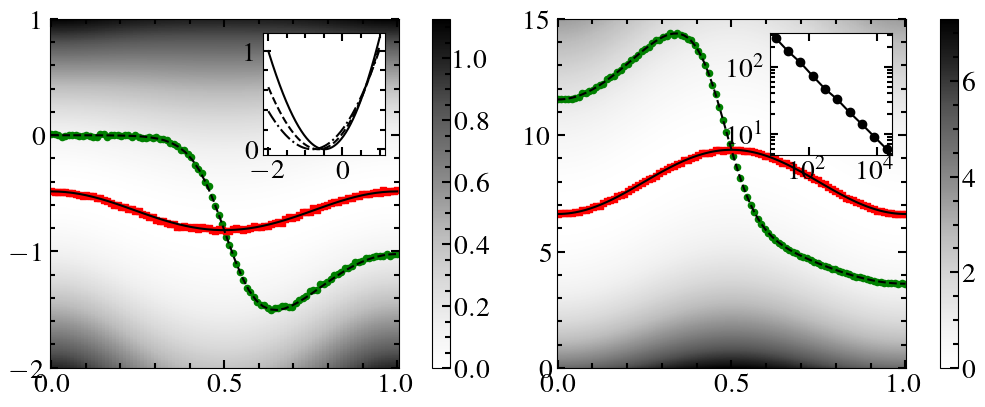

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), 
                       layout='compressed')

cbar_et = ax[0].pcolormesh(T_ent, K_ent, np.array(phi_en).real, cmap="Greys",rasterized=True)
cbar1 = fig.colorbar(cbar_et, ax=ax[0], pad=.05, fraction=0.05,  orientation='vertical')
#cbar1.ax.set_xlabel(r"$\mathcal{I}(\sigma)$", labelpad=-290, va='top')


#ax[0].set_xlabel(r"time $t/\tau$")
#ax[0].set_ylabel(r"$\sigma/\omega$")

#####################

ax[0].scatter(int_st, ent_st, color="green",marker="o", s=20)
ax[0].plot(stim_t, scf_st, color="black", linestyle="--")

#####################

ax[0].scatter(int_s0, ent_s0, color="red", marker="s", s=20)
ax[0].plot(stim_0, scf_s0, color="black")

#####################

inset_ax = inset_axes(ax[0], width="35%", height="35%", loc=1)  # loc=2 specifies the upper left corner
inset_ax.plot(phi_en_klist, np.array(phi_en).real[0], color="black", linestyle="-")
inset_ax.plot(phi_en_klist, np.array(phi_en).real[24],color="black", linestyle="--")
inset_ax.plot(phi_en_klist, np.array(phi_en).real[49],color="black",linestyle="-.")

#inset_ax.text(-0.8,0.8, r"$\mathcal{I}(\sigma)$", fontsize=20)

#inset_ax.set_xlabel(r"$\sigma$", labelpad=-20, loc='right', fontsize=20)

ax[0].set_box_aspect(1)

#####################
#####################
#####################
#####################

cbar_ac = ax[1].pcolormesh(T_act, K_act, np.array(phi_ac).real, cmap="Greys",rasterized=True)
cbar2 = fig.colorbar(cbar_ac, ax=ax[1], pad=.05, fraction=0.05,  orientation='vertical')
#cbar2.ax.set_xlabel(r"$\mathcal{I}(q)$", labelpad=-290, va='top')

#####################

#ax[1].set_xlabel(r"time $t/\tau$")
#ax[1].set_ylabel(r"$q/\omega$")

#####################

ax[1].scatter(int_activity_st, ent_activity_st, color="green", s=20)
ax[1].plot(stim_activity_t,scf_activity_st, color="black", linestyle="--")

#####################

ax[1].scatter(int_activity_s0, ent_activity_s0, color="red", marker="s",  s=20)
ax[1].plot(stim_activity_0, scf_activity_s0, color="black")

ax[1].set_box_aspect(1)

inset_ax1 = inset_axes(ax[1], width="35%", height="35%")  # loc=2 specifies the upper left corner
inset_ax1.plot(taulist, np.mean(error, axis=0), color="black", linestyle="-", marker="o" )
inset_ax1.set_xscale("log")
inset_ax1.set_yscale("log")


#####################

plt.savefig("Fig_entropy_prod.pdf")


In [32]:
len( np.array(phi_en).real)

100